In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# Load dataset CAvideos.csv
df = pd.read_csv("CAvideos.csv")

df.head()


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
1,0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,13030,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...
4,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...


In [2]:
def pilih_video_otomatis(df, min_points=5):
    counts = df.groupby('video_id').size().sort_values(ascending=False)
    for vid, cnt in counts.items():
        if cnt < min_points:
            break
        sub = df[df['video_id'] == vid].copy()
        sub = sub.sort_values('trending_date')
        views = sub['views'].values
        if np.all(np.diff(views) > 0):  # views selalu naik
            return vid, sub
    
    # fallback jika tidak ada yang monoton
    vid = counts.index[0]
    sub = df[df['video_id'] == vid].sort_values('trending_date')
    return vid, sub

video_id, df_vid = pilih_video_otomatis(df)

print("Video terpilih otomatis:")
print("ID Video   :", video_id)
print("Judul      :", df_vid['title'].iloc[0])
print("Channel    :", df_vid['channel_title'].iloc[0])

df_vid[['trending_date', 'views']].head()


Video terpilih otomatis:
ID Video   : UceaB4D0jpo
Judul      : Post Malone - rockstar ft. 21 Savage
Channel    : PostMaloneVEVO


,trending_date,views
1730,17.22.11,556200
1801,17.23.11,7558742
2001,17.24.11,11202281
2199,17.25.11,15162291
2401,17.26.11,19654814


In [3]:
df_vid = df_vid.sort_values('trending_date')

t_data = np.arange(len(df_vid))                 # t = 0,1,2,3,...
U_data = df_vid['views'].astype(float).values  # U(t) = views

t_data, U_data


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([  556200.,  7558742., 11202281., 15162291., 19654814., 24802714.,
        29753467., 34275219.]))

In [4]:
def estimate_params_limited_exp(t, U):
    Umax_est = U.max() * 1.1
    if np.any(U >= Umax_est):
        Umax_est = U.max() * 1.5

    y = np.log(Umax_est - U)
    slope, intercept = np.polyfit(t, y, 1)
    r_est = -slope
    return r_est, Umax_est, intercept

r_est, Umax_est, intercept = estimate_params_limited_exp(t_data, U_data)

print(f"Estimasi r     : {r_est:.4f}")
print(f"Estimasi U_max : {Umax_est:.0f}")
print(f"U0 (views awal): {U_data[0]:.0f}")


Estimasi r     : 0.3063
Estimasi U_max : 37702741
U0 (views awal): 556200


In [5]:
def model_pertumbuhan(U, t, r, Umax):
    return r * (Umax - U)

def euler_method(func, U0, t_points, params):
    U = np.zeros(len(t_points))
    U[0] = U0
    h = t_points[1] - t_points[0]

    for i in range(len(t_points)-1):
        slope = func(U[i], t_points[i], *params)
        U[i+1] = U[i] + h * slope
    return U

def rk4_method(func, U0, t_points, params):
    U = np.zeros(len(t_points))
    U[0] = U0
    h = t_points[1] - t_points[0]

    for i in range(len(t_points)-1):
        t = t_points[i]
        Ui = U[i]

        k1 = func(Ui, t, *params)
        k2 = func(Ui + 0.5*h*k1, t + 0.5*h, *params)
        k3 = func(Ui + 0.5*h*k2, t + 0.5*h, *params)
        k4 = func(Ui + h*k3, t + h, *params)

        U[i+1] = Ui + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    return U


In [6]:
t_points = t_data.astype(float)
U0 = U_data[0]
params = (r_est, Umax_est)

U_euler = euler_method(model_pertumbuhan, U0, t_points, params)
U_rk4   = rk4_method(model_pertumbuhan, U0, t_points, params)

print("Simulasi selesai.")


Simulasi selesai.


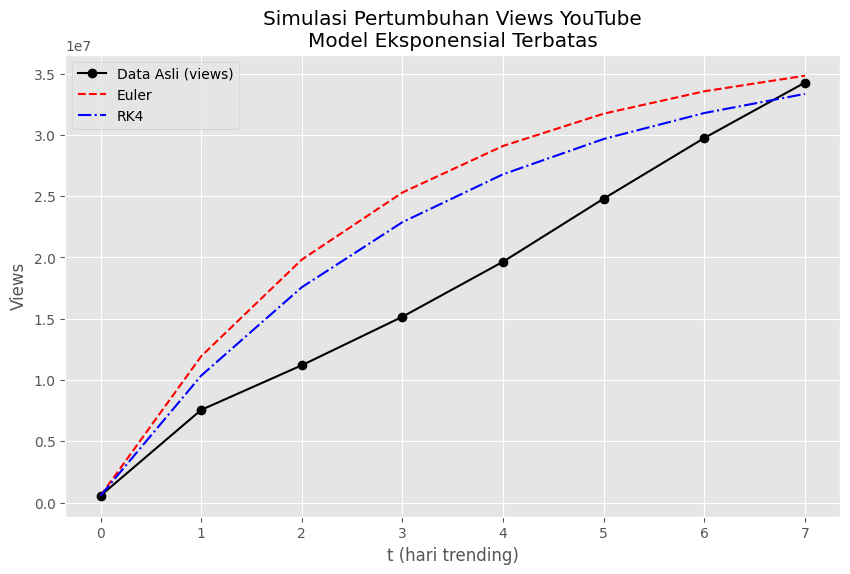

In [7]:
plt.figure(figsize=(10,6))

plt.plot(t_data, U_data, 'ko-', label='Data Asli (views)')
plt.plot(t_points, U_euler, 'r--', label='Euler')
plt.plot(t_points, U_rk4, 'b-.', label='RK4')

plt.xlabel("t (hari trending)")
plt.ylabel("Views")
plt.title("Simulasi Pertumbuhan Views YouTube\nModel Eksponensial Terbatas")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

print("MAE Euler :", mae(U_data, U_euler))
print("MAE RK4   :", mae(U_data, U_rk4))
print("MSE Euler :", mse(U_data, U_euler))
print("MSE RK4   :", mse(U_data, U_rk4))


MAE Euler : 5484971.942662064
MAE RK4   : 3980887.9909198917
MSE Euler : 43549541496310.234
MSE RK4   : 23443791973382.914
